<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/LoFTR_demo_single_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoFTR demo with custom image pairs on Colab


Download endonasal frames

In [1]:
#https://drive.google.com/file/d/1-WUCGHRf3kF4dXbHjHnl56TMsdQA_d4m/view?usp=sharing
import gdown
url = 'https://drive.google.com/uc?id=1-WUCGHRf3kF4dXbHjHnl56TMsdQA_d4m'
gdown.download(url,'endonasal_data.zip',quiet=True)
!unzip -q endonasal_data.zip

Download code and weights


In [2]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip -q install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights 
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

     |████████████████████████████████| 41 kB 502 kB/s 
     |████████████████████████████████| 551 kB 23.0 MB/s 
Cloning into 'LoFTR'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 173 (delta 26), reused 140 (delta 21), pack-reused 0
Receiving objects: 100% (173/173), 26.29 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/weights
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O 


#Example1 (thr = 0.8)

(131, 2)


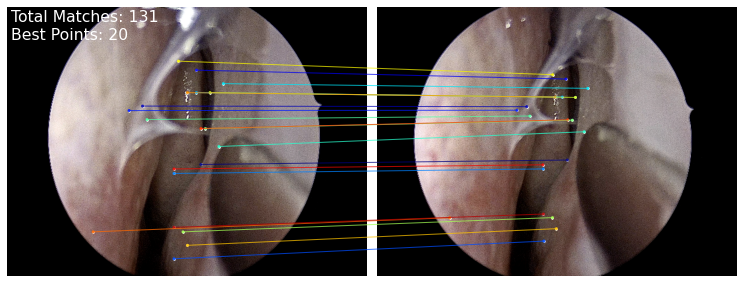

In [28]:


import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg
from google.colab import files
import random

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
image_type = 'outdoor'
default_cfg['match_coarse']['thr'] = 0.8
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

# Rerun this cell (and below) if a new image pair is uploaded.
img0_pth = "/content/endonasal_data/a1.png"
img1_pth = "/content/endonasal_data/a2.png"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

# Draw 
num_points = 20
num_list = random.sample(range(0, len(mkpts0)), num_points)
begin = 2850
# color = cm.jet(mconf[num_list], alpha=0.5)
color = cm.jet(np.arange(num_points)/num_points, alpha=0.7)
text = [
    'Total Matches: {}'.format(len(mkpts0)),
    'Best Points: {}'.format(len(mkpts0[num_list])),
]
img0_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[0]), (640, 480)), cv2.COLOR_BGR2RGB)
img1_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[1]), (640, 480)), cv2.COLOR_BGR2RGB)
fig = make_matching_figure(img0_raw_, img1_raw_, mkpts0[num_list], mkpts1[num_list], color, mkpts0[num_list], mkpts1[num_list], text)
print(mkpts0.shape)

#Example2 (thr = 0.8)

(2184, 2)


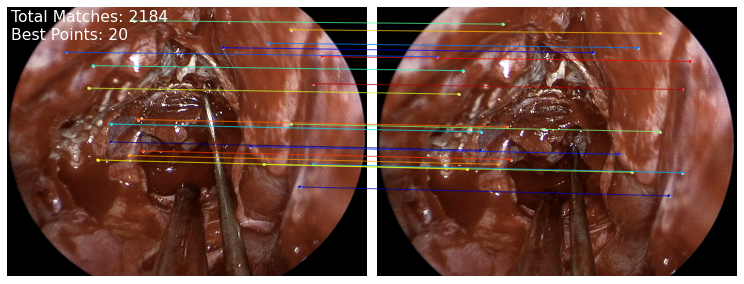

In [27]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_pth = "/content/endonasal_data/1.png"
img1_pth = "/content/endonasal_data/2.png"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

# Draw 
num_points = 20
num_list = random.sample(range(0, len(mkpts0)), num_points)
# color = cm.jet(mconf[num_list], alpha=0.5)
color = cm.jet(np.arange(num_points)/num_points, alpha=0.7)
text = [
    'Total Matches: {}'.format(len(mkpts0)),
    'Best Points: {}'.format(len(mkpts0[num_list])),
]

img0_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[0]), (640, 480)), cv2.COLOR_BGR2RGB)
img1_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[1]), (640, 480)), cv2.COLOR_BGR2RGB)
fig = make_matching_figure(img0_raw_, img1_raw_, mkpts0[num_list], mkpts1[num_list], color, mkpts0[num_list], mkpts1[num_list], text)
print(mkpts0.shape)

#Example1 (thr = 0.2)

(1103, 2)


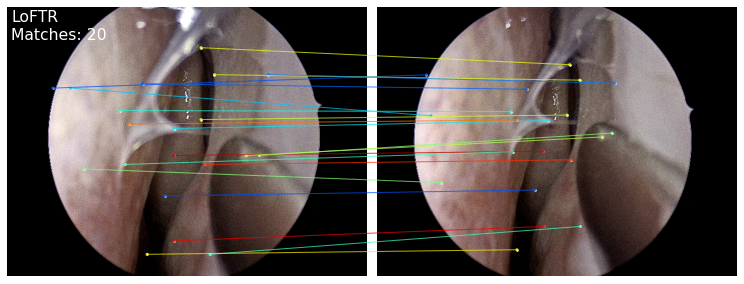

In [7]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg
from google.colab import files
import random

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
image_type = 'outdoor'
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

# Rerun this cell (and below) if a new image pair is uploaded.
img0_pth = "/content/endonasal_data/a1.png"
img1_pth = "/content/endonasal_data/a2.png"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

# Draw 
num_points = 20
num_list = random.sample(range(0, len(mkpts0)), num_points)
begin = 2850
color = cm.jet(mconf[num_list], alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0[num_list])),
]
img0_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[0]), (640, 480)), cv2.COLOR_BGR2RGB)
img1_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[1]), (640, 480)), cv2.COLOR_BGR2RGB)
fig = make_matching_figure(img0_raw_, img1_raw_, mkpts0[num_list], mkpts1[num_list], color, mkpts0[num_list], mkpts1[num_list], text)
print(mkpts0.shape)

#Example2 (thr = 0.2)

(3332, 2)


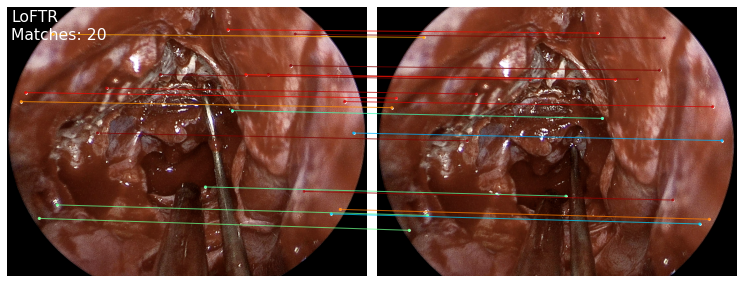

In [6]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_pth = "/content/endonasal_data/1.png"
img1_pth = "/content/endonasal_data/2.png"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

# Draw 
num_points = 20
num_list = random.sample(range(0, len(mkpts0)), num_points)
color = cm.jet(mconf[num_list], alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0[num_list])),
]

img0_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[0]), (640, 480)), cv2.COLOR_BGR2RGB)
img1_raw_ = cv2.cvtColor(cv2.resize(cv2.imread(image_pair[1]), (640, 480)), cv2.COLOR_BGR2RGB)
fig = make_matching_figure(img0_raw_, img1_raw_, mkpts0[num_list], mkpts1[num_list], color, mkpts0[num_list], mkpts1[num_list], text)
print(mkpts0.shape)